# Assignment 1: Bandits and Exploration/Exploitation

Welcome to Assignment 1. This notebook will:
- Help you create your first bandit algorithm
- Help you understand the effect of epsilon on exploration and learn about the exploration/exploitation tradeoff
- Introduce you to some of the reinforcement learning software we are going to use for this specialization

This class uses RL-Glue to implement most of our experiments. It was originally designed by Adam White, Brian Tanner, and Rich Sutton. This library will give you a solid framework to understand how reinforcement learning experiments work and how to run your own. If it feels a little confusing at first, don't worry - we are going to walk you through it slowly and introduce you to more and more parts as you progress through the specialization.

We are assuming that you have used a Jupyter notebook before. But if not, it is quite simple. Simply press the run button, or shift+enter to run each of the cells. The places in the code that you need to fill in will be clearly marked for you.

## Section 0: Preliminaries

In [1]:
# Import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from rlglue.rl_glue import RLGlue
import main_agent
import ten_arm_env
import test_env

In the above cell, we import the libraries we need for this assignment. We use numpy throughout the course and occasionally provide hints for which methods to use in numpy. Other than that we mostly use vanilla python and the occasional other library, such as matplotlib for making plots.

You might have noticed that we import ten_arm_env. This is the __10-armed Testbed__ introduced in [section 2.3](http://www.incompleteideas.net/book/RLbook2018.pdf) of the textbook. We use this throughout this notebook to test our bandit agents. It has 10 arms, which are the actions the agent can take. Pulling an arm generates a stochastic reward from a Gaussian distribution with unit-variance. For each action, the expected value of that action is randomly sampled from a normal distribution, at the start of each run. If you are unfamiliar with the 10-armed Testbed please review it in the textbook before continuing.

__DO NOT IMPORT OTHER LIBRARIES as this will break the autograder.__

__DO NOT SET A RANDOM SEED as this will break the autograder.__

Please **do not** duplicate cells. This will put your notebook into a bad state and break Cousera's autograder.

Before you submit, please click "Kernel" -> "Restart and Run All" and make sure all cells pass.

## Section 1: Greedy Agent

We want to create an agent that will find the action with the highest expected reward. One way an agent could operate is to always choose the action with  the highest value based on the agent’s current estimates. This is called a greedy agent as it greedily chooses the action that it thinks has the highest value. Let's look at what happens in this case.

First we are going to implement the argmax function, which takes in a list of action values and returns an action with the highest value. Why are we implementing our own instead of using the argmax function that numpy uses? Numpy's argmax function returns the first instance of the highest value. We do not want that to happen as it biases the agent to choose a specific action in the case of ties. Instead we want to break ties between the highest values randomly. So we are going to implement our own argmax function. You may want to look at [np.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html) to randomly select from a list of values.

In [2]:
# -----------
# Graded Cell
# -----------
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index of the item 
    with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top_value = float("-inf")
    ties = list()
    
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value update top and reset ties to zero
        # if a value is equal to top value add the index to ties
        # return a random selection from ties.
        # YOUR CODE HERE
        if q_values[i] > top_value:
            ties = [i]
            top_value = q_values[i]
            print(ties)
            
        elif q_values[i] == top_value:
            ties.append(i)
        
        elif q_values[i] < top_value: 
            pass
#         raise NotImplementedError()
    return np.random.choice(ties)

In [3]:
# --------------
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

test_array = [1, 110, 110, 10, 110, 4, 0, 0, 1, 7]
# assert argmax(test_array) == 8, "Check your argmax implementation returns the index of the largest value"


# make sure np.random.choice is called correctly
# np.random.seed(0)
# test_array = [1, 0, 0, 1]

argmax(test_array)
# assert argmax(test_array) == 0

[0]
[1]


1

In [4]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8, "Check your argmax implementation returns the index of the largest value"

# set random seed so results are deterministic
np.random.seed(0)
test_array = [1, 0, 0, 1]

counts = [0, 0, 0, 0]
for _ in range(100):
    a = argmax(test_array)
    counts[a] += 1

# make sure argmax does not always choose first entry
assert counts[0] != 100, "Make sure your argmax implementation randomly choooses among the largest values."

# make sure argmax does not always choose last entry
assert counts[3] != 100, "Make sure your argmax implementation randomly choooses among the largest values."

# make sure the random number generator is called exactly once whenver `argmax` is called
expected = [44, 0, 0, 56] # <-- notice not perfectly uniform due to randomness
assert counts == expected

[0]
[8]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


Now we introduce the first part of an RL-Glue agent that you will implement. Here we are going to create a GreedyAgent and implement the agent_step method. This method gets called each time the agent takes a step. The method has to return the action selected by the agent. This method also ensures the agent’s estimates are updated based on the signals it gets from the environment.

Fill in the code below to implement a greedy agent.

In [5]:
# -----------
# Graded Cell
# -----------
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation=None):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent recieved from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this as you will not use it
                              until future lessons
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        ### Useful Class Variables ###
        # self.q_values : An array with what the agent believes each of the values of the arm are.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step
        #######################
        
        # Update Q values Hint: Look at the algorithm in section 2.4 of the textbook.
        # increment the counter in self.arm_count for the action from the previous time step
        # update the step size using self.arm_count
        # update self.q_values for the action from the previous time step

        
        # YOUR CODE HERE
        self.arm_count[self.last_action] += 1
        self.q_values[self.last_action] += (reward - self.q_values[self.last_action]) / self.arm_count[self.last_action]
        
        # current action = ? # Use the argmax function you created above
        # YOUR CODE HERE
        current_action = argmax(self.q_values)
        self.last_action = current_action
        
        return current_action
        

In [6]:
# --------------
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

# build a fake agent for testing and set some initial conditions
# np.random.seed(1)/
greedy_agent = GreedyAgent()
greedy_agent.q_values = [0, 0, 0.5, 0, 0]
greedy_agent.arm_count = [0, 1, 0, 0, 0]
greedy_agent.last_action = 0

action = greedy_agent.agent_step(reward=-1)
action = greedy_agent.agent_step(reward=-4)
action = greedy_agent.agent_step(reward=-2)
action = greedy_agent.agent_step(reward=-5)
action = greedy_agent.agent_step(reward=-2)
action = greedy_agent.agent_step(reward=-5)

print(greedy_agent.q_values)
print(greedy_agent.arm_count)
print(greedy_agent.last_action)

# make sure the q_values were updated correctly
# assert greedy_agent.q_values == [0, 0.5, 0.5, 0, 0]

# make sure the agent is using the argmax that breaks ties randomly
# assert action == 2

[0]
[1]
[2]
[0]
[1]
[0]
[1]
[0]
[4]
[0]
[0]
[1]
[3]
[-3.0, -2.5, -4.0, -2.0, -2.0]
[2, 2, 1, 1, 1]
3


In [7]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

# build a fake agent for testing and set some initial conditions
greedy_agent = GreedyAgent()
greedy_agent.q_values = [0, 0, 1.0, 0, 0]
greedy_agent.arm_count = [0, 1, 0, 0, 0]
greedy_agent.last_action = 1

# take a fake agent step
action = greedy_agent.agent_step(reward=1)

# make sure agent took greedy action
assert action == 2

# make sure q_values were updated correctly
assert greedy_agent.q_values == [0, 0.5, 1.0, 0, 0]

# take another step
action = greedy_agent.agent_step(reward=2)
assert action == 2
assert greedy_agent.q_values == [0, 0.5, 2.0, 0, 0]

[0]
[1]
[2]
[0]
[1]
[2]


Let's visualize the result. Here we run an experiment using RL-Glue to test our agent. For now, we will set up the experiment code; in future lessons, we will walk you through running experiments so that you can create your own.

  0%|          | 0/200 [00:00<?, ?it/s]

[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]


  0%|          | 1/200 [00:00<00:46,  4.26it/s]

[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]


  1%|          | 2/200 [00:00<00:49,  4.00it/s]

[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]


  2%|▏         | 4/200 [00:00<00:45,  4.30it/s]

[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[0]
[0]
[0]
[0]
[9]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


  2%|▎         | 5/200 [00:01<00:46,  4.15it/s]

[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]


  3%|▎         | 6/200 [00:01<00:49,  3.94it/s]

[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]


  4%|▎         | 7/200 [00:01<00:50,  3.81it/s]

[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]


  4%|▍         | 8/200 [00:01<00:42,  4.50it/s]

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


  4%|▍         | 9/200 [00:02<00:46,  4.14it/s]

[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


  5%|▌         | 10/200 [00:02<00:47,  3.97it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]


  6%|▌         | 11/200 [00:02<00:47,  3.98it/s]

[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]


  6%|▌         | 12/200 [00:03<00:48,  3.85it/s]

[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


  6%|▋         | 13/200 [00:03<00:50,  3.70it/s]

[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]


  7%|▋         | 14/200 [00:03<00:51,  3.64it/s]

[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]


  8%|▊         | 15/200 [00:03<00:43,  4.29it/s]

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


  8%|▊         | 16/200 [00:04<00:45,  4.02it/s]

[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[0]
[6]
[0]
[0]
[0]
[0]
[0]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[0]
[0]
[2]
[3]
[4]
[0]
[2]
[3]
[4]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]


  8%|▊         | 17/200 [00:04<01:00,  3.04it/s]

[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]
[2]
[3]
[7]
[0]


  9%|▉         | 18/200 [00:04<00:58,  3.14it/s]

[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]


 10%|▉         | 19/200 [00:05<00:56,  3.23it/s]

[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]


 10%|█         | 20/200 [00:05<00:54,  3.29it/s]

[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]


 10%|█         | 21/200 [00:05<00:53,  3.35it/s]

[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]


 11%|█         | 22/200 [00:05<00:52,  3.39it/s]

[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]


 12%|█▏        | 23/200 [00:06<00:49,  3.55it/s]

[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[0]
[0]
[0]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]


 12%|█▏        | 24/200 [00:06<00:50,  3.52it/s]

[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]


 12%|█▎        | 25/200 [00:06<00:50,  3.49it/s]

[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]


 13%|█▎        | 26/200 [00:06<00:43,  4.02it/s]

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


 14%|█▎        | 27/200 [00:07<00:43,  3.98it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[0]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]


 14%|█▍        | 28/200 [00:07<00:45,  3.80it/s]

[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]


 14%|█▍        | 29/200 [00:07<00:46,  3.71it/s]

[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]


 15%|█▌        | 30/200 [00:08<00:46,  3.63it/s]

[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]


 16%|█▌        | 31/200 [00:08<00:52,  3.20it/s]

[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]


 16%|█▌        | 32/200 [00:09<01:02,  2.67it/s]

[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]
[2]
[7]
[0]
[1]


 16%|█▋        | 33/200 [00:09<00:58,  2.87it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 17%|█▋        | 34/200 [00:09<00:55,  3.02it/s]

[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]


 18%|█▊        | 35/200 [00:09<00:52,  3.14it/s]

[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[4]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]


 18%|█▊        | 36/200 [00:10<01:02,  2.61it/s]

[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]
[6]
[0]
[1]
[5]


 18%|█▊        | 37/200 [00:10<00:57,  2.83it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]


 19%|█▉        | 38/200 [00:10<00:54,  2.98it/s]

[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]


 20%|█▉        | 39/200 [00:11<00:51,  3.12it/s]

[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]


 20%|██        | 40/200 [00:11<00:49,  3.21it/s]

[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]


 20%|██        | 41/200 [00:11<00:54,  2.93it/s]

[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]
[2]
[6]
[0]


 21%|██        | 42/200 [00:12<00:51,  3.07it/s]

[0]
[7]
[0]
[4]
[0]
[4]
[0]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]


 22%|██▏       | 43/200 [00:12<00:47,  3.27it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 22%|██▏       | 44/200 [00:12<00:51,  3.00it/s]


[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]

 22%|██▎       | 45/200 [00:13<00:49,  3.12it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 23%|██▎       | 46/200 [00:13<00:47,  3.24it/s]

[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]


 24%|██▎       | 47/200 [00:13<00:46,  3.27it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 24%|██▍       | 48/200 [00:14<00:45,  3.34it/s]

[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]


 24%|██▍       | 49/200 [00:14<00:44,  3.37it/s]

[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]


 25%|██▌       | 50/200 [00:14<00:42,  3.50it/s]

[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]


 26%|██▌       | 51/200 [00:14<00:42,  3.48it/s]

[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]


 26%|██▌       | 52/200 [00:15<00:42,  3.47it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 26%|██▋       | 53/200 [00:15<00:42,  3.50it/s]

[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[0]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]


 27%|██▋       | 54/200 [00:15<00:41,  3.48it/s]

[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]


 28%|██▊       | 55/200 [00:16<00:39,  3.63it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 28%|██▊       | 56/200 [00:16<00:40,  3.58it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]


 28%|██▊       | 57/200 [00:16<00:45,  3.16it/s]

[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]


 29%|██▉       | 58/200 [00:17<00:55,  2.57it/s]

[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]
[1]
[3]
[8]
[0]


 30%|██▉       | 59/200 [00:17<00:55,  2.55it/s]

[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]


 30%|███       | 60/200 [00:17<00:49,  2.85it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 30%|███       | 61/200 [00:18<00:46,  3.00it/s]

[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]


 31%|███       | 62/200 [00:18<00:43,  3.15it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[1]
[0]
[1]
[0]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]


 32%|███▏      | 63/200 [00:18<00:42,  3.25it/s]

[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]


 32%|███▏      | 64/200 [00:19<00:45,  2.97it/s]

[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]


 32%|███▎      | 65/200 [00:19<00:43,  3.10it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]


 33%|███▎      | 66/200 [00:20<00:51,  2.63it/s]

[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]


 34%|███▎      | 67/200 [00:20<00:46,  2.84it/s]

[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]


 34%|███▍      | 68/200 [00:20<00:43,  3.01it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]


 34%|███▍      | 69/200 [00:20<00:40,  3.25it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]


 36%|███▌      | 71/200 [00:21<00:33,  3.86it/s]

[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


 36%|███▋      | 73/200 [00:21<00:29,  4.34it/s]

[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


 37%|███▋      | 74/200 [00:21<00:29,  4.26it/s]

[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]


 38%|███▊      | 75/200 [00:22<00:33,  3.79it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]


 38%|███▊      | 76/200 [00:22<00:32,  3.84it/s]

[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]


 38%|███▊      | 77/200 [00:22<00:33,  3.72it/s]

[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]


 39%|███▉      | 78/200 [00:23<00:33,  3.68it/s]

[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]


 40%|███▉      | 79/200 [00:23<00:37,  3.23it/s]

[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]


 40%|████      | 80/200 [00:23<00:35,  3.42it/s]


[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]

 40%|████      | 81/200 [00:24<00:34,  3.42it/s]

[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]


 41%|████      | 82/200 [00:24<00:34,  3.46it/s]

[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]


 42%|████▏     | 83/200 [00:24<00:29,  3.98it/s]

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


 42%|████▏     | 84/200 [00:24<00:29,  3.97it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]


 42%|████▎     | 85/200 [00:25<00:34,  3.37it/s]

[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]


 43%|████▎     | 86/200 [00:25<00:33,  3.43it/s]

[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]


 44%|████▎     | 87/200 [00:25<00:32,  3.45it/s]

[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]


 44%|████▍     | 88/200 [00:25<00:32,  3.45it/s]

[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]


 44%|████▍     | 89/200 [00:26<00:32,  3.46it/s]

[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]


 45%|████▌     | 90/200 [00:26<00:39,  2.79it/s]

[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]
[1]
[2]
[5]
[0]


 46%|████▌     | 91/200 [00:27<00:36,  2.96it/s]

[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]


 46%|████▌     | 92/200 [00:27<00:33,  3.20it/s]

[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[2]
[0]
[2]
[0]
[0]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]


 46%|████▋     | 93/200 [00:27<00:32,  3.30it/s]

[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]


 47%|████▋     | 94/200 [00:27<00:31,  3.36it/s]

[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]


 48%|████▊     | 95/200 [00:28<00:30,  3.40it/s]

[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]


 48%|████▊     | 96/200 [00:28<00:29,  3.56it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]


 48%|████▊     | 97/200 [00:28<00:29,  3.52it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]


 49%|████▉     | 98/200 [00:29<00:29,  3.50it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]


 50%|████▉     | 99/200 [00:29<00:28,  3.51it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 50%|█████     | 100/200 [00:29<00:28,  3.51it/s]


[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[1]
[0]
[1]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]

 50%|█████     | 101/200 [00:29<00:31,  3.15it/s]


[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]

 51%|█████     | 102/200 [00:30<00:29,  3.36it/s]


[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]

 52%|█████▏    | 103/200 [00:30<00:28,  3.39it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 52%|█████▏    | 104/200 [00:30<00:28,  3.41it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 52%|█████▎    | 105/200 [00:31<00:31,  3.04it/s]


[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]

 53%|█████▎    | 106/200 [00:31<00:31,  2.95it/s]

[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 54%|█████▎    | 107/200 [00:31<00:33,  2.77it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]


 54%|█████▍    | 108/200 [00:32<00:35,  2.61it/s]

[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]
[1]
[8]
[0]


 55%|█████▍    | 109/200 [00:32<00:32,  2.82it/s]


[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]

 55%|█████▌    | 110/200 [00:33<00:30,  2.99it/s]

[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]


 56%|█████▌    | 111/200 [00:33<00:31,  2.84it/s]


[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[1]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]

 56%|█████▌    | 112/200 [00:33<00:29,  2.98it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 56%|█████▋    | 113/200 [00:33<00:23,  3.63it/s]

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


 57%|█████▋    | 114/200 [00:34<00:23,  3.60it/s]


[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]

 57%|█████▊    | 115/200 [00:34<00:26,  3.18it/s]

[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]
[1]
[3]
[0]


 58%|█████▊    | 116/200 [00:34<00:25,  3.27it/s]

[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[0]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[0]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]


 58%|█████▊    | 117/200 [00:35<00:24,  3.34it/s]

[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]


 59%|█████▉    | 118/200 [00:35<00:23,  3.51it/s]

[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]


 60%|█████▉    | 119/200 [00:35<00:23,  3.50it/s]

[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]


 60%|██████    | 120/200 [00:35<00:22,  3.49it/s]

[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]


 60%|██████    | 121/200 [00:36<00:22,  3.54it/s]

[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]


 61%|██████    | 122/200 [00:36<00:22,  3.48it/s]

[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]


 62%|██████▏   | 123/200 [00:36<00:18,  4.19it/s]

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]


 62%|██████▏   | 124/200 [00:36<00:19,  3.96it/s]

[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]


 62%|██████▎   | 125/200 [00:37<00:22,  3.34it/s]

[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]
[2]
[7]
[0]


 63%|██████▎   | 126/200 [00:37<00:24,  3.00it/s]

[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]
[0]
[2]
[9]


 64%|██████▎   | 127/200 [00:38<00:23,  3.13it/s]

[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]


 64%|██████▍   | 128/200 [00:38<00:22,  3.24it/s]

[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]


 64%|██████▍   | 129/200 [00:38<00:21,  3.31it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 65%|██████▌   | 130/200 [00:38<00:20,  3.50it/s]

[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]


 66%|██████▌   | 131/200 [00:39<00:19,  3.48it/s]

[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]


 66%|██████▌   | 132/200 [00:39<00:19,  3.51it/s]

[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]


 66%|██████▋   | 133/200 [00:39<00:19,  3.49it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 67%|██████▋   | 134/200 [00:39<00:18,  3.63it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 68%|██████▊   | 135/200 [00:40<00:18,  3.59it/s]

[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[0]
[0]
[0]
[7]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]


 68%|██████▊   | 136/200 [00:40<00:17,  3.56it/s]

[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]


 68%|██████▊   | 137/200 [00:40<00:17,  3.54it/s]

[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]


 69%|██████▉   | 138/200 [00:41<00:16,  3.69it/s]

[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]


 70%|██████▉   | 139/200 [00:41<00:16,  3.60it/s]

[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]


 70%|███████   | 140/200 [00:41<00:13,  4.39it/s]

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


 70%|███████   | 141/200 [00:41<00:15,  3.84it/s]

[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]


 71%|███████   | 142/200 [00:42<00:15,  3.64it/s]

[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]


 72%|███████▏  | 143/200 [00:42<00:15,  3.73it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]


 72%|███████▏  | 144/200 [00:42<00:15,  3.66it/s]

[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]


 72%|███████▎  | 145/200 [00:42<00:15,  3.60it/s]

[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]


 73%|███████▎  | 146/200 [00:43<00:15,  3.58it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]


 74%|███████▎  | 147/200 [00:43<00:12,  4.25it/s]

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


 74%|███████▍  | 148/200 [00:43<00:13,  3.98it/s]

[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]


 74%|███████▍  | 149/200 [00:43<00:13,  3.84it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 75%|███████▌  | 150/200 [00:44<00:11,  4.52it/s]

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]


 76%|███████▌  | 151/200 [00:44<00:11,  4.19it/s]


[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]

 76%|███████▌  | 152/200 [00:44<00:12,  3.94it/s]

[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]


 76%|███████▋  | 153/200 [00:44<00:12,  3.76it/s]

[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]


 77%|███████▋  | 154/200 [00:45<00:12,  3.67it/s]

[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]


 78%|███████▊  | 155/200 [00:45<00:12,  3.75it/s]


[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]

 78%|███████▊  | 156/200 [00:45<00:12,  3.65it/s]

[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]


 78%|███████▊  | 157/200 [00:46<00:16,  2.58it/s]

[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]
[4]
[0]
[1]
[2]
[3]


 79%|███████▉  | 158/200 [00:46<00:14,  2.88it/s]


[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]

 80%|███████▉  | 159/200 [00:46<00:13,  3.03it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]


 80%|████████  | 160/200 [00:47<00:12,  3.16it/s]

[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]


 80%|████████  | 161/200 [00:47<00:11,  3.29it/s]

[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[0]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]


 81%|████████  | 162/200 [00:47<00:11,  3.45it/s]

[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]


 82%|████████▏ | 163/200 [00:48<00:10,  3.44it/s]

[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]


 82%|████████▏ | 164/200 [00:48<00:11,  3.10it/s]


[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]
[0]
[1]
[5]

 82%|████████▎ | 165/200 [00:48<00:10,  3.21it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 83%|████████▎ | 166/200 [00:48<00:10,  3.31it/s]

[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]


 84%|████████▎ | 167/200 [00:49<00:09,  3.35it/s]

[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]


 84%|████████▍ | 168/200 [00:49<00:09,  3.37it/s]

[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]


 84%|████████▍ | 169/200 [00:49<00:10,  3.04it/s]

[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]
[1]
[7]
[0]


 85%|████████▌ | 170/200 [00:50<00:10,  2.85it/s]


[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]
[6]
[0]
[1]

 86%|████████▌ | 171/200 [00:50<00:09,  3.11it/s]

[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]


 86%|████████▋ | 173/200 [00:51<00:07,  3.73it/s]

[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]


 87%|████████▋ | 174/200 [00:51<00:07,  3.65it/s]

[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]


 88%|████████▊ | 175/200 [00:51<00:06,  3.72it/s]

[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[8]


 88%|████████▊ | 176/200 [00:51<00:06,  3.69it/s]

[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]


 88%|████████▊ | 177/200 [00:52<00:07,  3.22it/s]

[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]


 89%|████████▉ | 178/200 [00:52<00:06,  3.30it/s]

[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]
[0]
[7]


 90%|████████▉ | 179/200 [00:52<00:06,  3.37it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]


 90%|█████████ | 180/200 [00:53<00:05,  3.53it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]


 90%|█████████ | 181/200 [00:53<00:06,  3.13it/s]

[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]
[0]
[1]
[9]


 91%|█████████ | 182/200 [00:53<00:05,  3.24it/s]

[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]
[0]
[9]


 92%|█████████▏| 183/200 [00:54<00:05,  3.30it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]


 92%|█████████▏| 184/200 [00:54<00:04,  3.36it/s]

[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]


 92%|█████████▎| 185/200 [00:54<00:04,  3.40it/s]

[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]


 93%|█████████▎| 186/200 [00:54<00:03,  3.55it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 94%|█████████▎| 187/200 [00:55<00:03,  3.54it/s]

[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]


 94%|█████████▍| 188/200 [00:55<00:03,  3.49it/s]

[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[4]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]


 94%|█████████▍| 189/200 [00:55<00:03,  3.50it/s]

[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]
[0]
[3]


 95%|█████████▌| 190/200 [00:56<00:02,  3.48it/s]

[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]


 96%|█████████▌| 191/200 [00:56<00:02,  4.17it/s]

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


 96%|█████████▌| 192/200 [00:56<00:02,  3.47it/s]

[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]
[1]
[4]
[0]


 96%|█████████▋| 193/200 [00:56<00:02,  3.48it/s]

[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[2]


 97%|█████████▋| 194/200 [00:57<00:01,  4.15it/s]

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


 98%|█████████▊| 196/200 [00:57<00:00,  4.39it/s]

[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


 98%|█████████▊| 197/200 [00:57<00:00,  4.05it/s]

[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]
[0]
[5]


 99%|█████████▉| 198/200 [00:58<00:00,  4.04it/s]

[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]


100%|█████████▉| 199/200 [00:58<00:00,  4.48it/s]

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


100%|██████████| 200/200 [00:58<00:00,  3.42it/s]

[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]
[0]
[6]


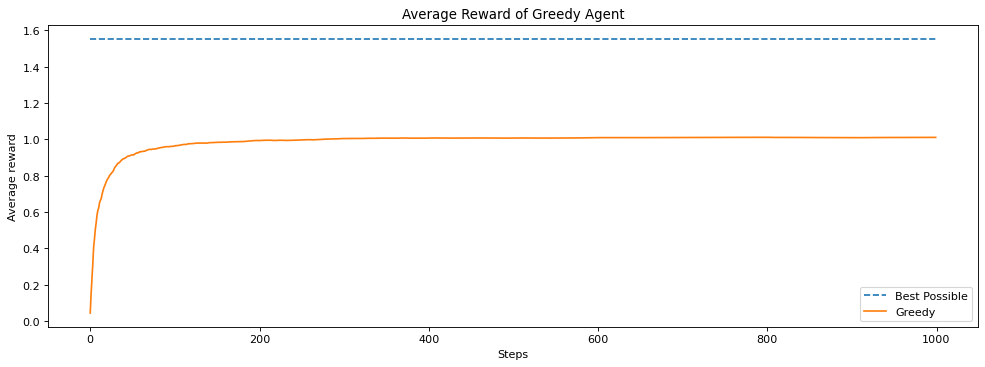

In [8]:
# ---------------
# Discussion Cell
# ---------------

num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of pulls of each arm the agent takes
env = ten_arm_env.Environment     # We set what environment we want to use to test
agent = GreedyAgent               # We choose what agent we want to use
agent_info = {"num_actions": 10}  # We pass the agent the information it needs. Here how many arms there are.
env_info = {}                     # We pass the environment the information it needs. In this case nothing.

all_averages = []

average_best = 0
for run in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # We start the experiment

    average_best += np.max(rl_glue.environment.arms)
    
    scores = [0]
    averages = []
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([average_best / num_runs for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)

How did our agent do? Is it possible for it to do better?

## Section 2: Epsilon-Greedy Agent

We learned about [another way for an agent to operate](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning/lecture/tHDck/what-is-the-trade-off), where it does not always take the greedy action. Instead, sometimes it takes an exploratory action. It does this so that it can find out what the best action really is. If we always choose what we think is the current best action is, we may miss out on taking the true best action, because we haven't explored enough times to find that best action.

Implement an epsilon-greedy agent below. Hint: we are implementing the algorithm from [section 2.4](http://www.incompleteideas.net/book/RLbook2018.pdf#page=52) of the textbook. You may want to use your greedy code from above and look at [np.random.random](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.random.html), as well as [np.random.randint](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html), to help you select random actions. 

In [9]:
# -----------
# Graded Cell
# -----------
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent recieved from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this as you will not use it
                              until future lessons
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array with what the agent believes each of the values of the arm are.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        #######################
        
        # Update Q values - this should be the same update as your greedy agent above
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # Choose action using epsilon greedy
        # Randomly choose a number between 0 and 1 and see if it's less than self.epsilon
        # (hint: look at np.random.random()). If it is, set current_action to a random action.
        # otherwise choose current_action greedily as you did above.
        # YOUR CODE HERE
        raise NotImplementedError()
        
        self.last_action = current_action
        
        return current_action

In [ ]:
# --------------
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

# build a fake agent for testing and set some initial conditions
np.random.seed(0)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0.0, 0.5, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5

# given this random seed, we should see a greedy action (action 2) here
action = e_greedy_agent.agent_step(reward=1, observation=0)

# -----------------------------------------------
# we'll try to guess a few of the trickier places
# -----------------------------------------------

# make sure to update for the *last_action* not the current action
assert e_greedy_agent.q_values != [0, 0.5, 1.0, 0, 0], "A"

# make sure the stepsize is based on the *last_action* not the current action
assert e_greedy_agent.q_values != [0, 1, 0.5, 0, 0], "B"

# make sure the agent is using the argmax that breaks ties randomly
assert action == 2, "C"

# -----------------------------------------------

# let's see what happens for another action
np.random.seed(1)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0.5, 0.5, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5

# given this random seed, we should see a random action (action 4) here
action = e_greedy_agent.agent_step(reward=1, observation=0)

# The agent saw a reward of 1, so should increase the value for *last_action*
assert e_greedy_agent.q_values == [0, 0.75, 0.5, 0, 0], "D"

# the agent should have picked a random action for this particular random seed
assert action == 4, "E"


In [ ]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

np.random.seed(0)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5
action = e_greedy_agent.agent_step(reward=1, observation=0)

assert e_greedy_agent.q_values == [0, 0.5, 1.0, 0, 0]

# manipulate the random seed so the agent takes a random action
np.random.seed(1)
action = e_greedy_agent.agent_step(reward=0, observation=0)

assert action == 4

# check to make sure we update value for action 4
action = e_greedy_agent.agent_step(reward=1, observation=0)
assert e_greedy_agent.q_values == [0, 0.5, 0.0, 0, 1.0]

Now that we have our epsilon greedy agent created. Let's compare it against the greedy agent with epsilon of 0.1.

In [ ]:
# ---------------
# Discussion Cell
# ---------------

# Plot Epsilon greedy results and greedy results
num_runs = 200
num_steps = 1000
epsilon = 0.1
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": epsilon}
env_info = {}
all_averages = []

for run in tqdm(range(num_runs)):
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    averages = []
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.title("Average Reward of Greedy Agent vs. E-Greedy Agent")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(("Best Possible", "Greedy", "Epsilon: 0.1"))
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Notice how much better the epsilon-greedy agent did. Because we occasionally choose a random action we were able to find a better long term policy. By acting greedily before our value estimates are accurate, we risk settling on a suboptimal action.

## Section 2.1 Averaging Multiple Runs

Did you notice that we averaged over 200 runs? Why did we do that?

To get some insight, let's look at the results of two individual runs by the same agent.

In [ ]:
# ---------------
# Discussion Cell
# ---------------

# Plot runs of e-greedy agent
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": 0.1}
env_info = {}
all_averages = []
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
num_steps = 1000

for run in (0, 1):
    np.random.seed(run) # Here we set the seed so that we can compare two different runs
    averages = []
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    for i in range(num_steps):
        reward, state, action, is_terminal = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    
    plt.plot(averages)

plt.title("Comparing two independent runs")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Notice how the two runs were different? But, if this is the exact same algorithm, why does it behave differently in these two runs?

The answer is that it is due to randomness in the environment and in the agent. Depending on what action the agent randomly starts with, or when it randomly chooses to explore, it can change the results of the runs. And even if the agent chooses the same action, the reward from the environment is randomly sampled from a Gaussian. The agent could get lucky, and see larger rewards for the best action early on and so settle on the best action faster. Or, it could get unlucky and see smaller rewards for best action early on and so take longer to recognize that it is in fact the best action.

To be more concrete, let’s look at how many times an exploratory action is taken, for different seeds. 

In [ ]:
# ---------------
# Discussion Cell
# ---------------
print("Random Seed 1")
np.random.seed(1)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Exploratory Action")
    

print()
print()

print("Random Seed 2")
np.random.seed(2)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Exploratory Action")

With the first seed, we take an exploratory action three times out of 15, but with the second, we only take an exploratory action once. This can significantly affect the performance of our agent because the amount of exploration has changed significantly.

To compare algorithms, we therefore report performance averaged across many runs. We do this to ensure that we are not simply reporting a result that is due to stochasticity, as explained [in the lectures](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning/lecture/PtVBs/sequential-decision-making-with-evaluative-feedback). Rather, we want statistically significant outcomes. We will not use statistical significance tests in this course. Instead, because we have access to simulators for our experiments, we use the simpler strategy of running for a large number of runs and ensuring that the confidence intervals do not overlap. 

## Section 3: Comparing values of epsilon

Can we do better than an epsilon of 0.1? Let's try several different values for epsilon and see how they perform. We try different settings of key performance parameters to understand how the agent might perform under different conditions.

Below we run an experiment where we sweep over different values for epsilon:

In [ ]:
# ---------------
# Discussion Cell
# ---------------

# Experiment code for different e-greedy
epsilons = [0.0, 0.01, 0.1, 0.4]

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

n_q_values = []
n_averages = []
n_best_actions = []

num_runs = 200

for epsilon in epsilons:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        best_action_chosen = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))
        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))

plt.legend(["Best Possible"] + epsilons)
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Why did 0.1 perform better than 0.01?

If exploration helps why did 0.4 perform worse that 0.0 (the greedy agent)?

Think about these and how you would answer these questions. They are questions in the practice quiz. If you still have questions about it, retake the practice quiz.

## Section 4: The Effect of Step Size

In Section 1 of this assignment, we decayed the step size over time based on action-selection counts. The step-size was 1/N(A), where N(A) is the number of times action A was selected. This is the same as computing a sample average. We could also set the step size to be a constant value, such as 0.1. What would be the effect of doing that? And is it better to use a constant or the sample average method? 

To investigate this question, let’s start by creating a new agent that has a constant step size. This will be nearly identical to the agent created above. You will use the same code to select the epsilon-greedy action. You will change the update to have a constant step size instead of using the 1/N(A) update.

In [ ]:
# -----------
# Graded Cell
# -----------
class EpsilonGreedyAgentConstantStepsize(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent recieved from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this as you will not use it
                              until future lessons
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array with what the agent believes each of the values of the arm are.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : An int of the action that the agent took on the previous time step.
        # self.step_size : A float which is the current step size for the agent.
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        #######################
        
        # Update q_values for action taken at previous time step 
        # using self.step_size intead of using self.arm_count
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # Choose action using epsilon greedy. This is the same as you implemented above.
        # YOUR CODE HERE
        raise NotImplementedError()
        
        self.last_action = current_action
        
        return current_action

In [ ]:
# --------------
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

for step_size in [0.01, 0.1, 0.5, 1.0]:
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize()
    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action = 1
    e_greedy_agent.epsilon = 0.0
    e_greedy_agent.step_size = step_size
    action = e_greedy_agent.agent_step(1, 0)
    assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0], "Check that you are updating q_values correctly using the stepsize."

In [ ]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

np.random.seed(0)
# Check Epsilon Greedy with Different Constant Stepsizes
for step_size in [0.01, 0.1, 0.5, 1.0]:
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize()
    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action = 1
    e_greedy_agent.epsilon = 0.0
    e_greedy_agent.step_size = step_size
    
    action = e_greedy_agent.agent_step(1, 0)
    
    assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0]    

In [ ]:
# ---------------
# Discussion Cell
# ---------------

# Experiment code for different step sizes
step_sizes = [0.01, 0.1, 0.5, 1.0, '1/N(A)']

epsilon = 0.1
num_steps = 1000
num_runs = 200

fig, ax = plt.subplots(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    all_averages = []
    for run in tqdm(range(num_runs)):
        np.random.seed(run)
        agent = EpsilonGreedyAgentConstantStepsize if step_size != '1/N(A)' else EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size, "initial_value": 0.0}
        env_info = {}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        
        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)
            
        best_action_chosen = []
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        best_actions[step_size].append(best_action_chosen)
    ax.plot(np.mean(best_actions[step_size], axis=0))

plt.legend(step_sizes)
plt.title("% Best Arm Pulled")
plt.xlabel("Steps")
plt.ylabel("% Best Arm Pulled")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

Notice first that we are now plotting the amount of time that the best action is taken rather than the average reward. To better  understand the performance of an agent, it can be useful to measure specific behaviors, beyond just how much reward is accumulated. This measure indicates how close the agent’s behaviour is to optimal.

It seems as though 1/N(A) performed better than the others, in that it reaches a solution where it takes the best action most frequently. Now why might this be? Why did a step size of 0.5 start out better but end up performing worse? Why did a step size of 0.01 perform so poorly?

Let's dig into this further below. Let’s plot how well each agent tracks the true value, where each agent has a different step size method. You do not have to enter any code here, just follow along.

In [ ]:
# ---------------
# Discussion Cell
# ---------------
largest = 0
num_steps = 1000
for step_size in step_sizes:
    plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    largest = np.argmax(true_values[step_size])
    plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
    plt.title("Step Size: {}".format(step_size))
    plt.plot(np.array(q_values[step_size])[:, largest])
    plt.legend(["True Expected Value", "Estimated Value"])
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.show()

These plots help clarify the performance differences between the different step sizes. A step size of 0.01 makes such small updates that the agent’s value estimate of the best action does not get close to the actual value. Step sizes of 0.5 and 1.0 both get close to the true value quickly, but are very susceptible to stochasticity in the rewards. The updates overcorrect too much towards recent rewards, and so oscillate around the true value. This means that on many steps, the action that pulls the best arm may seem worse than it actually is.  A step size of 0.1 updates fairly quickly to the true value, and does not oscillate as widely around the true values as 0.5 and 1.0. This is one of the reasons that 0.1 performs quite well. Finally we see why 1/N(A) performed well. Early on while the step size is still reasonably high it moves quickly to the true expected value, but as it gets pulled more its step size is reduced which makes it less susceptible to the stochasticity of the rewards.

Does this mean that 1/N(A) is always the best? When might it not be? One possible setting where it might not be as effective is in non-stationary problems. You learned about non-stationarity in the lessons. Non-stationarity means that the environment may change over time. This could manifest itself as continual change over time of the environment, or a sudden change in the environment.

Let's look at how a sudden change in the reward distributions affects a step size like 1/N(A). This time we will run the environment for 2000 steps, and after 1000 steps we will randomly change the expected value of all of the arms. We compare two agents, both using epsilon-greedy with epsilon = 0.1. One uses a constant step size of 0.1, the other a step size of 1/N(A) that reduces over time. 

In [ ]:
# ---------------
# Discussion Cell
# ---------------
epsilon = 0.1
num_steps = 2000
num_runs = 200
step_size = 0.1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

for agent in [EpsilonGreedyAgent, EpsilonGreedyAgentConstantStepsize]:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}
        np.random.seed(run)
        
        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        scores = [0]
        averages = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if i == 1000:
                rl_glue.environment.arms = np.random.randn(10)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "1/N(A)", "0.1"])
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Now the agent with a step size of 1/N(A) performed better at the start but then performed worse when the environment changed! What happened?

Think about what the step size would be after 1000 steps. Let's say the best action gets chosen 500 times. That means the step size for that action is 1/500 or 0.002. At each step when we update the value of the action and the value is going to move only 0.002 * the error. That is a very tiny adjustment and it will take a long time for it to get to the true value.

The agent with step size 0.1, however, will always update in 1/10th of the direction of the error. This means that on average it will take ten steps for it to update its value to the sample mean.

These are the types of tradeoffs we have to think about in reinforcement learning. A larger step size moves us more quickly toward the true value, but can make our estimated values oscillate around the expected value. A step size that reduces over time can converge to close to the expected value, without oscillating. On the other hand, such a decaying stepsize is not able to adapt to changes in the environment. Nonstationarity---and the related concept of partial observability---is a common feature of reinforcement learning problems and when learning online.  

## Section 5: Conclusion

Great work! You have:
- Implemented your first agent
- Learned about the effect of epsilon, an exploration parameter, on the performance of an agent
- Learned about the effect of step size on the performance of the agent
- Learned about a good experiment practice of averaging across multiple runs